In [1]:
import sys
from neurodsp.sim import set_random_seed
from neurodsp.sim import sim_powerlaw, sim_oscillation
from neurodsp.utils import create_times
from neurodsp.plts import plot_timefrequency#

from neurodsp.timefrequency import compute_wavelet_transform
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import pandas as pd

import matplotlib as mpl
new_rc_params = {'text.usetex': False,
                 "svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

set_random_seed(42)

from pyrasa.irasa import irasa_sprint

In [2]:
# Set some general settings, to be used across all simulations
fs = 500
n_seconds = 15
duration=4
overlap=0.5

# Create a times vector for the simulations
times = create_times(n_seconds, fs)


alpha = sim_oscillation(n_seconds=.5, fs=fs, freq=10)
no_alpha = np.zeros(len(alpha))
beta = sim_oscillation(n_seconds=.5, fs=fs, freq=25)
no_beta = np.zeros(len(beta))

exp_1 = sim_powerlaw(n_seconds=2.5, fs=fs, exponent=-1)
exp_2 = sim_powerlaw(n_seconds=2.5, fs=fs, exponent=-2)


alphas = np.concatenate([no_alpha, alpha, no_alpha, alpha, no_alpha])
betas = np.concatenate([beta, no_beta, beta, no_beta, beta])

sim_ts = np.concatenate([exp_1 + alphas, 
                         exp_1 + alphas + betas, 
                         exp_1 + betas, 
                         exp_2 + alphas, 
                         exp_2 + alphas + betas, 
                         exp_2 + betas, ])

In [3]:
freqs = np.arange(1, 100, 0.5)
import scipy.signal as dsp

mwt = compute_wavelet_transform(sim_ts, fs=fs, 
                                freqs=freqs, n_cycles=11,
                                )

irasa_sprint_spectrum = irasa_sprint(sim_ts[np.newaxis, :], fs=fs,
                                                       band=(1, 100),
                                                       freq_res=.5,
                                                       hop=25,
                                                       win_duration=1,
                                                       hset_info=(1.05, 2., 0.05),
                                                       win_func=dsp.windows.hann)

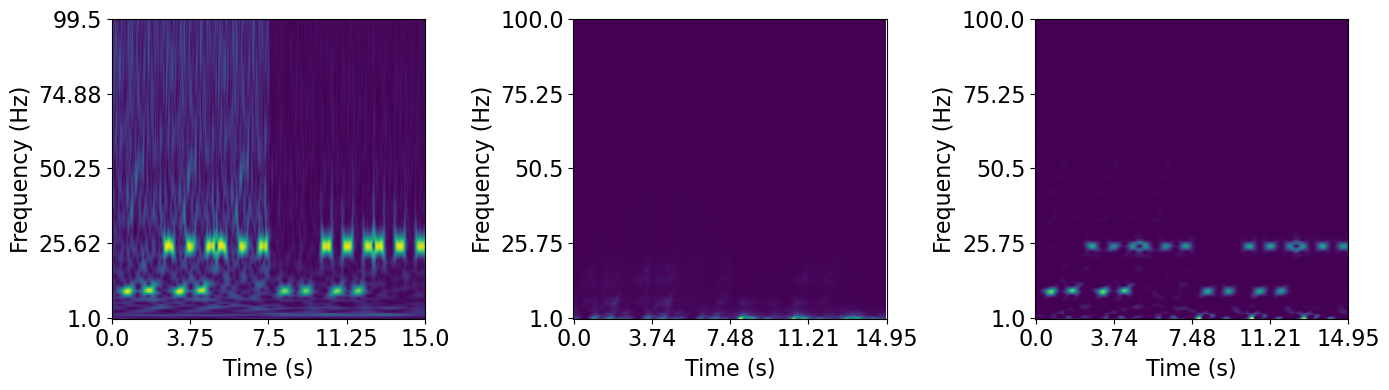

In [4]:
#%%
f, axes = plt.subplots(figsize=(14, 4), ncols=3)
mwt = np.abs(mwt)
plot_timefrequency(times, freqs, mwt, vmin=0, ax=axes[0])
plot_timefrequency(irasa_sprint_spectrum.time, irasa_sprint_spectrum.freqs, np.squeeze(irasa_sprint_spectrum.aperiodic), vmin=0, ax=axes[1])
plot_timefrequency(irasa_sprint_spectrum.time, irasa_sprint_spectrum.freqs, np.squeeze(irasa_sprint_spectrum.periodic), vmin=0, ax=axes[2])

In [5]:
ap_spec = irasa_sprint_spectrum.fit_aperiodic_model()

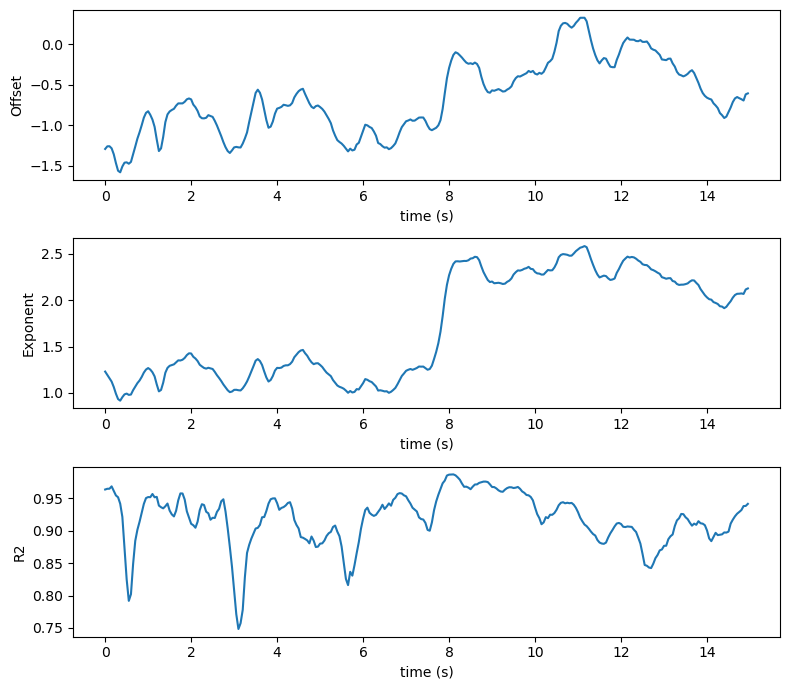

In [6]:
f, ax = plt.subplots(nrows=3, figsize=(8, 7))

ax[0].plot(ap_spec.aperiodic_params['time'], ap_spec.aperiodic_params['Offset'])
ax[0].set_ylabel('Offset')
ax[0].set_xlabel('time (s)')
ax[1].plot(ap_spec.aperiodic_params['time'], ap_spec.aperiodic_params['Exponent'])
ax[1].set_ylabel('Exponent')
ax[1].set_xlabel('time (s)')
ax[2].plot(ap_spec.aperiodic_params['time'], ap_spec.gof['r_squared'])
ax[2].set_ylabel('R2')
ax[2].set_xlabel('time (s)')

f.tight_layout()

In [7]:
peaks_spec = irasa_sprint_spectrum.get_peaks(cut_spectrum=(1, 40),
                                  smooth=True,
                                  smoothing_window=1,
                                  peak_threshold=1,
                                  min_peak_height=0.01,
                                  peak_width_limits=(0.5, 12))

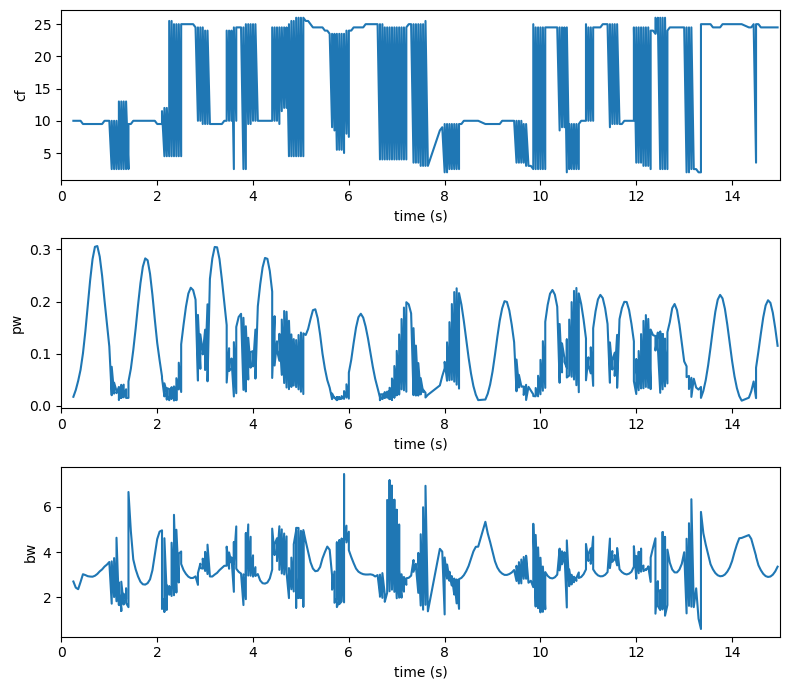

In [8]:
f, ax = plt.subplots(nrows=3, figsize=(8, 7))

for ix, cur_key in enumerate(['cf', 'pw', 'bw']):

    ax[ix].plot(peaks_spec['time'], peaks_spec[cur_key])
    ax[ix].set_ylabel(cur_key)
    ax[ix].set_xlabel('time (s)')
    ax[ix].set_xlim(0, 15)

f.tight_layout()

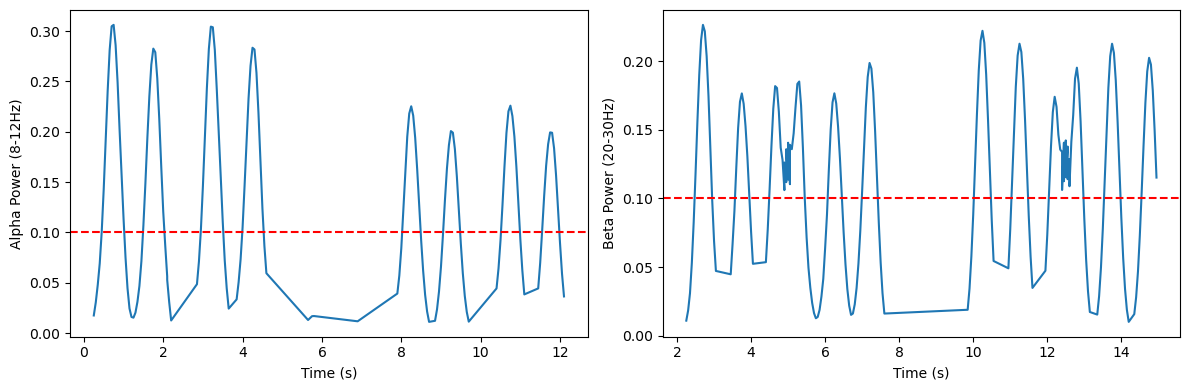

In [9]:
from pyrasa.utils.peak_utils import get_band_info

df_alpha = get_band_info(peaks_spec, freq_range=(8,12), ch_names=[])
alpha_peaks = df_alpha.query('pw > 0.10')

beta_ts = alpha_peaks['time'].to_numpy()
t1 = beta_ts[0]
n_peaks = 0
for ix, i in enumerate(beta_ts):
    try: 
        diff = beta_ts[ix + 1] - i
        if diff > 0.025:
            n_peaks += 1
    except IndexError:
        pass
n_peaks

#%%
df_beta = get_band_info(peaks_spec, freq_range=(20, 30), ch_names=[])
beta_peaks = df_beta.query('pw > 0.10')

beta_ts = beta_peaks['time'].to_numpy()
t1 = beta_ts[0]
n_peaks = 0
for ix, i in enumerate(beta_ts):
    try: 
        diff = beta_ts[ix + 1] - i
        if diff > 0.025:
            n_peaks += 1
    except IndexError:
        pass
n_peaks


# %%
f, ax = plt.subplots(figsize=(12, 4), ncols=2)

ax[0].plot(df_alpha['time'], df_alpha['pw'])
ax[1].plot(df_beta['time'], df_beta['pw'])

yax = ['Alpha Power (8-12Hz)', 'Beta Power (20-30Hz)']
for ix, c_ax in enumerate(ax):
    c_ax.axhline(0.1, color='r', linestyle='--')
    c_ax.set_xlabel('Time (s)')
    c_ax.set_ylabel(yax[ix])

f.tight_layout()